In [1]:
# ===== Cell 1: Imports =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import os
import math

In [2]:
# ===== Cell 2: Model Definitions =====
class InitialConvBlock(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class FusionBlock(nn.Module):
    def __init__(self, in_channels=128, out_channels=64):
        super().__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, f1, f2):
        fused = torch.cat([f1, f2], dim=1)
        return self.fuse(fused)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class EDSRBackbone(nn.Module):
    def __init__(self, channels=64, num_blocks=8):
        super().__init__()
        self.blocks = nn.Sequential(*[ResidualBlock(channels) for _ in range(num_blocks)])

    def forward(self, x):
        return self.blocks(x)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels=64, scale=4):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * scale**2, kernel_size=3, padding=1),
            nn.PixelShuffle(scale),
            nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.upsample(x)

class DualImageSR(nn.Module):
    def __init__(self, in_channels=1, scale=4):
        super().__init__()
        self.conv1 = InitialConvBlock(in_channels, 64)
        self.conv2 = InitialConvBlock(in_channels, 64)
        self.fusion = FusionBlock()
        self.backbone = EDSRBackbone()
        self.upsample = UpsampleBlock(scale=scale)

    def forward(self, lr1, lr2):
        f1 = self.conv1(lr1)
        f2 = self.conv2(lr2)
        fused = self.fusion(f1, f2)
        refined = self.backbone(fused)
        return self.upsample(refined)

In [3]:
# ===== Cell 3: Dataset Classes =====
class DualImageSRDataset(Dataset):
    def __init__(self, root_dir, hr_image_size=(256, 256)):
        self.lr_dir = os.path.join(root_dir, "low_res")
        self.hr_dir = os.path.join(root_dir, "high_res")
        self.filenames = sorted([f.replace("_LR0.png", "") for f in os.listdir(self.lr_dir) if f.endswith("_LR0.png")])

        self.hr_transform = transforms.Compose([
            transforms.Resize(hr_image_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_image_size[0] // 4, hr_image_size[1] // 4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        base = self.filenames[idx]
        lr1 = self.lr_transform(Image.open(os.path.join(self.lr_dir, f"{base}_LR0.png")).convert('L'))
        lr2 = self.lr_transform(Image.open(os.path.join(self.lr_dir, f"{base}_LR1.png")).convert('L'))
        hr = self.hr_transform(Image.open(os.path.join(self.hr_dir, f"{base}_HR.png")).convert('L'))

        return {"lr1": lr1, "lr2": lr2, "hr": hr}

In [4]:
# ===== Cell 4: Training Utilities =====
def calculate_psnr(sr, hr, max_val=1.0):
    mse = F.mse_loss(sr, hr)
    return 100 if mse == 0 else 20 * math.log10(max_val / math.sqrt(mse))



In [5]:
# ===== Cell 5: Training Loop =====
train_ds = DualImageSRDataset("Dual_SR_Dataset/train")
test_ds = DualImageSRDataset("Dual_SR_Dataset/test")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualImageSR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

os.makedirs("Image_outputs/Model", exist_ok=True)
os.makedirs("Image_outputs/visuals", exist_ok=True)

for epoch in range(1, 11):
    model.train()
    total_loss = 0

    for batch in train_loader:
        lr1 = batch['lr1'].to(device)
        lr2 = batch['lr2'].to(device)
        hr  = batch['hr'].to(device)

        sr = model(lr1, lr2)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f}")


Epoch 1 | Train Loss: 0.1053
Epoch 2 | Train Loss: 0.0867
Epoch 3 | Train Loss: 0.0806
Epoch 4 | Train Loss: 0.0787
Epoch 5 | Train Loss: 0.0787
Epoch 6 | Train Loss: 0.0759
Epoch 7 | Train Loss: 0.0756
Epoch 8 | Train Loss: 0.0756
Epoch 9 | Train Loss: 0.0743
Epoch 10 | Train Loss: 0.0739


In [7]:
# 🔥 Save model after every epoch
torch.save(model.state_dict(), f"Image_outputs/Model/dual_image_sr_epoch_{epoch}.pth")
print(f"✅ Model saved: Image_outputs/Model/dual_image_sr_epoch_{epoch}.pth")


✅ Model saved: Image_outputs/Model/dual_image_sr_epoch_10.pth


In [8]:

# ===== Cell 6: Evaluation and Visualizations =====
model.eval()
os.makedirs("Image_outputs/visuals", exist_ok=True)

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        lr1 = batch['lr1'].to(device)
        lr2 = batch['lr2'].to(device)
        hr  = batch['hr'].to(device)

        sr = model(lr1, lr2)

        save_image(sr, f"Image_outputs/visuals/sr_sample_{i}.png")
        save_image(hr, f"Image_outputs/visuals/hr_sample_{i}.png")


In [10]:

# ===== Cell 7: Blind Inference =====
class BlindTestDataset(Dataset):
    def __init__(self, low_res_dir):
        self.low_res_dir = low_res_dir
        self.filenames = sorted(set([
            f.replace("_LR0.png", "").replace("_LR1.png", "")
            for f in os.listdir(low_res_dir) if f.endswith(".png")
        ]))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        base = self.filenames[idx]
        lr1 = self.transform(Image.open(os.path.join(self.low_res_dir, f"{base}_LR0.png")).convert('L'))
        lr2 = self.transform(Image.open(os.path.join(self.low_res_dir, f"{base}_LR1.png")).convert('L'))
        return {"lr1": lr1, "lr2": lr2, "id": base}


# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load model safely on the same device
model = DualImageSR().to(device)
model.load_state_dict(torch.load("Image_outputs/Model/dual_image_sr_epoch_10.pth", map_location=device))
model.eval()

blind_ds = BlindTestDataset("Dual_SR_Dataset/blind_test_set")
blind_loader = DataLoader(blind_ds, batch_size=1, shuffle=False)

os.makedirs("Image_outputs/blind_sr_outputs", exist_ok=True)

with torch.no_grad():
    for batch in blind_loader:
        lr1 = batch['lr1'].to(device)
        lr2 = batch['lr2'].to(device)
        img_id = batch['id'][0]

        sr = model(lr1, lr2)

        save_image(sr, f"Image_outputs/blind_sr_outputs/{img_id}_SR.png")
        print(f"✅ Saved: {img_id}_SR.png")


✅ Saved: imgset1160_SR.png
✅ Saved: imgset1161_SR.png
✅ Saved: imgset1162_SR.png
✅ Saved: imgset1163_SR.png
✅ Saved: imgset1164_SR.png
✅ Saved: imgset1165_SR.png
✅ Saved: imgset1166_SR.png
✅ Saved: imgset1167_SR.png
✅ Saved: imgset1168_SR.png
✅ Saved: imgset1169_SR.png
✅ Saved: imgset1170_SR.png
✅ Saved: imgset1171_SR.png
✅ Saved: imgset1172_SR.png
✅ Saved: imgset1173_SR.png
✅ Saved: imgset1174_SR.png
✅ Saved: imgset1175_SR.png
✅ Saved: imgset1176_SR.png
✅ Saved: imgset1177_SR.png
✅ Saved: imgset1178_SR.png
✅ Saved: imgset1179_SR.png
✅ Saved: imgset1180_SR.png
✅ Saved: imgset1181_SR.png
✅ Saved: imgset1182_SR.png
✅ Saved: imgset1183_SR.png
✅ Saved: imgset1184_SR.png
✅ Saved: imgset1185_SR.png
✅ Saved: imgset1186_SR.png
✅ Saved: imgset1187_SR.png
✅ Saved: imgset1188_SR.png
✅ Saved: imgset1189_SR.png
✅ Saved: imgset1190_SR.png
✅ Saved: imgset1191_SR.png
✅ Saved: imgset1192_SR.png
✅ Saved: imgset1193_SR.png
✅ Saved: imgset1194_SR.png
✅ Saved: imgset1195_SR.png
✅ Saved: imgset1196_SR.png
✅

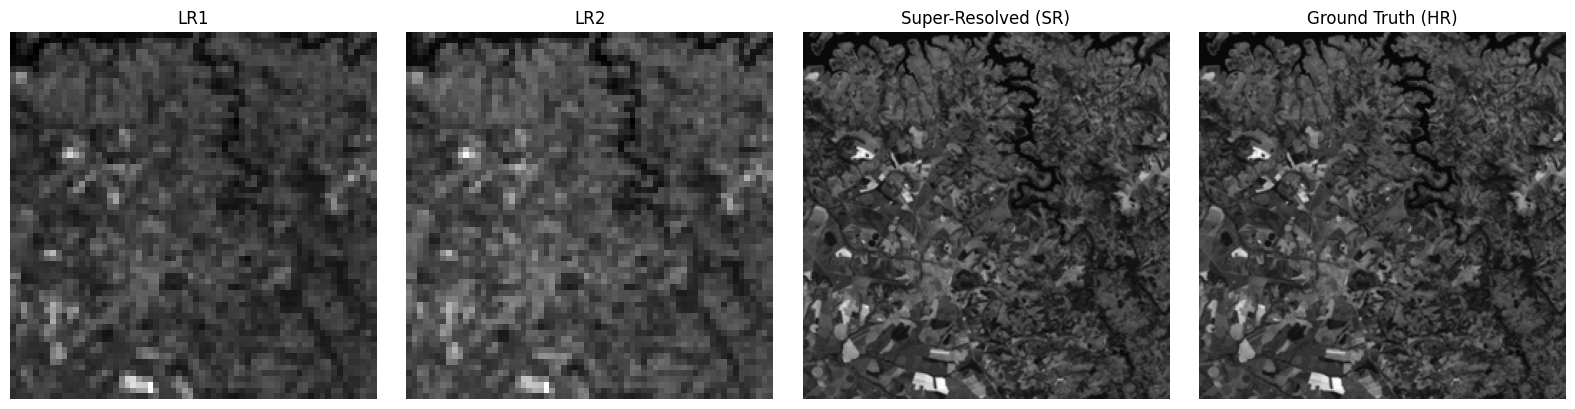

✅ Saved: Image_outputs/visuals/lr1_sample_0.png, Image_outputs/visuals/lr2_sample_0.png,Image_outputs/visuals/sr_sample_0.png, Image_outputs/visuals/hr_sample_0.png, 


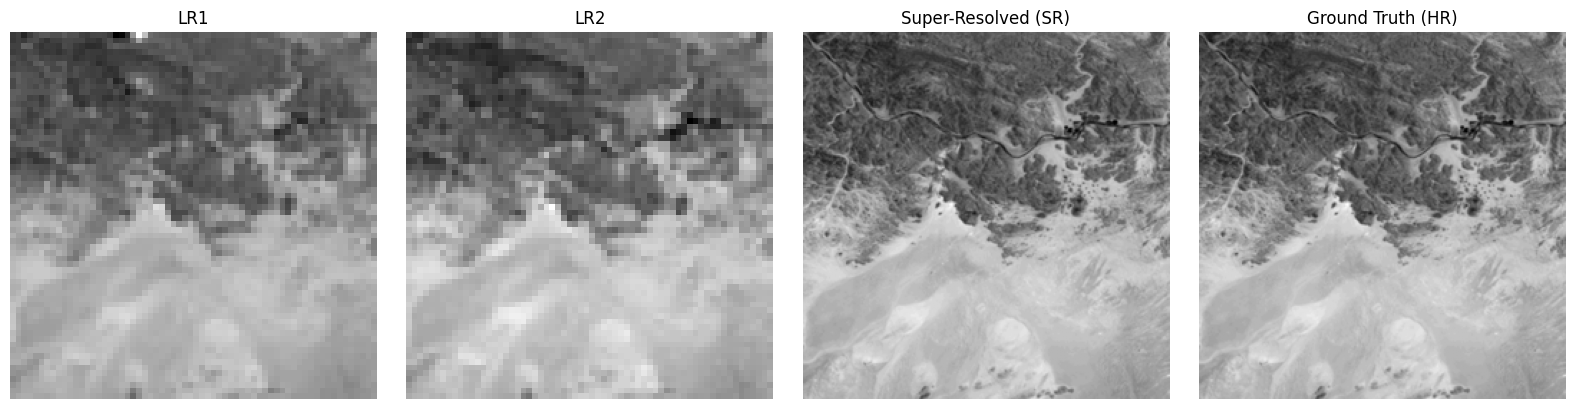

✅ Saved: Image_outputs/visuals/lr1_sample_1.png, Image_outputs/visuals/lr2_sample_1.png,Image_outputs/visuals/sr_sample_1.png, Image_outputs/visuals/hr_sample_1.png, 


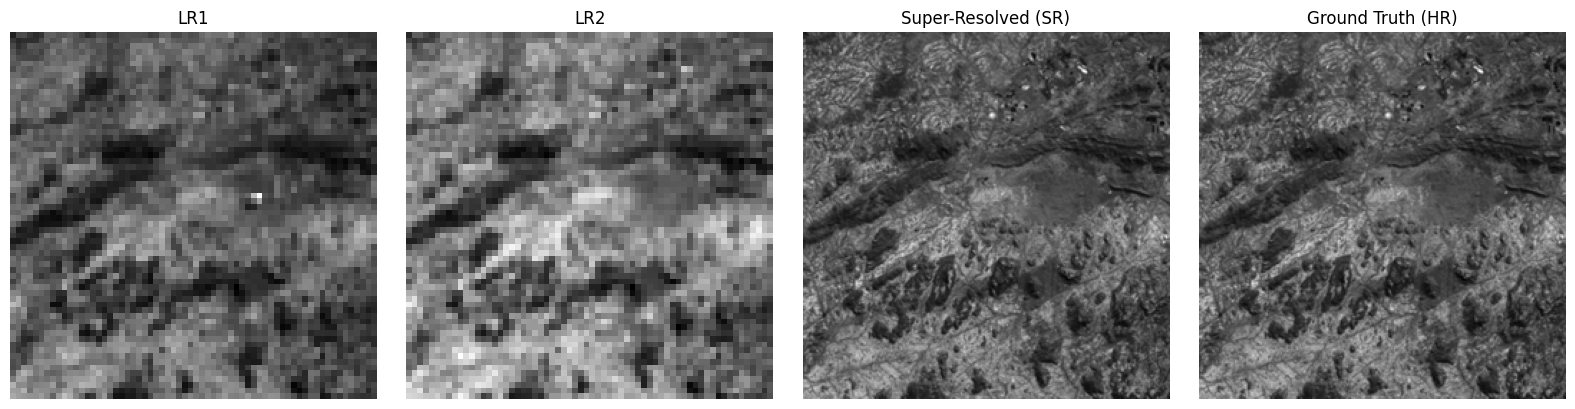

✅ Saved: Image_outputs/visuals/lr1_sample_2.png, Image_outputs/visuals/lr2_sample_2.png,Image_outputs/visuals/sr_sample_2.png, Image_outputs/visuals/hr_sample_2.png, 


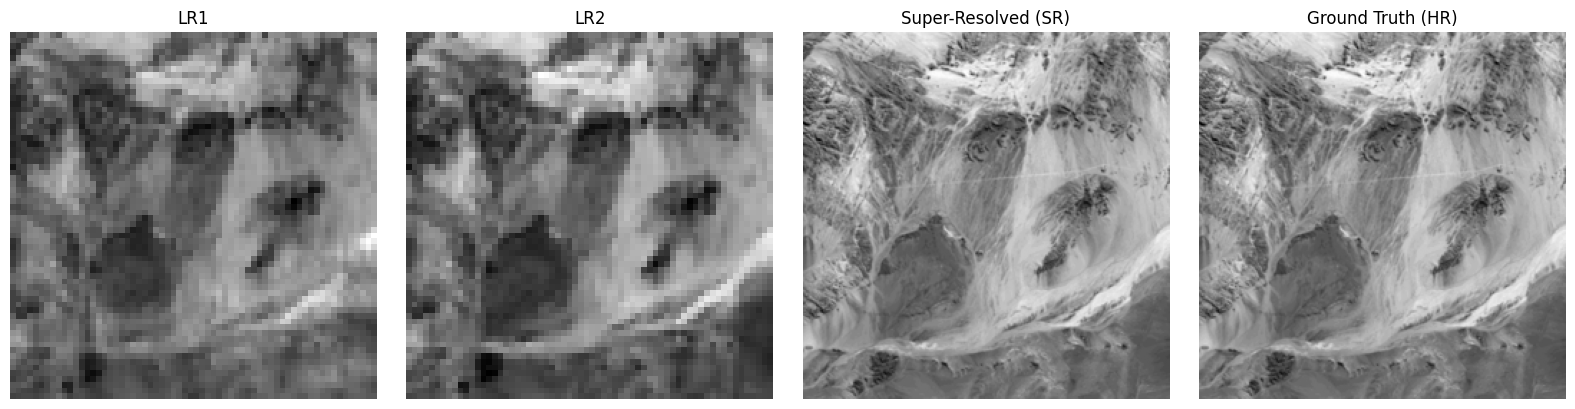

✅ Saved: Image_outputs/visuals/lr1_sample_3.png, Image_outputs/visuals/lr2_sample_3.png,Image_outputs/visuals/sr_sample_3.png, Image_outputs/visuals/hr_sample_3.png, 


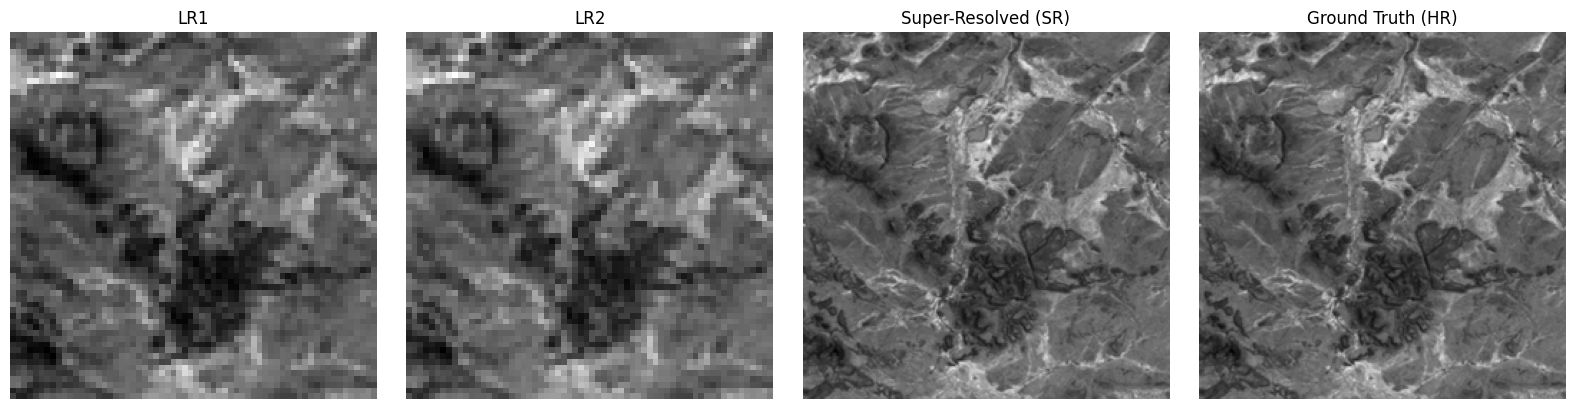

✅ Saved: Image_outputs/visuals/lr1_sample_4.png, Image_outputs/visuals/lr2_sample_4.png,Image_outputs/visuals/sr_sample_4.png, Image_outputs/visuals/hr_sample_4.png, 


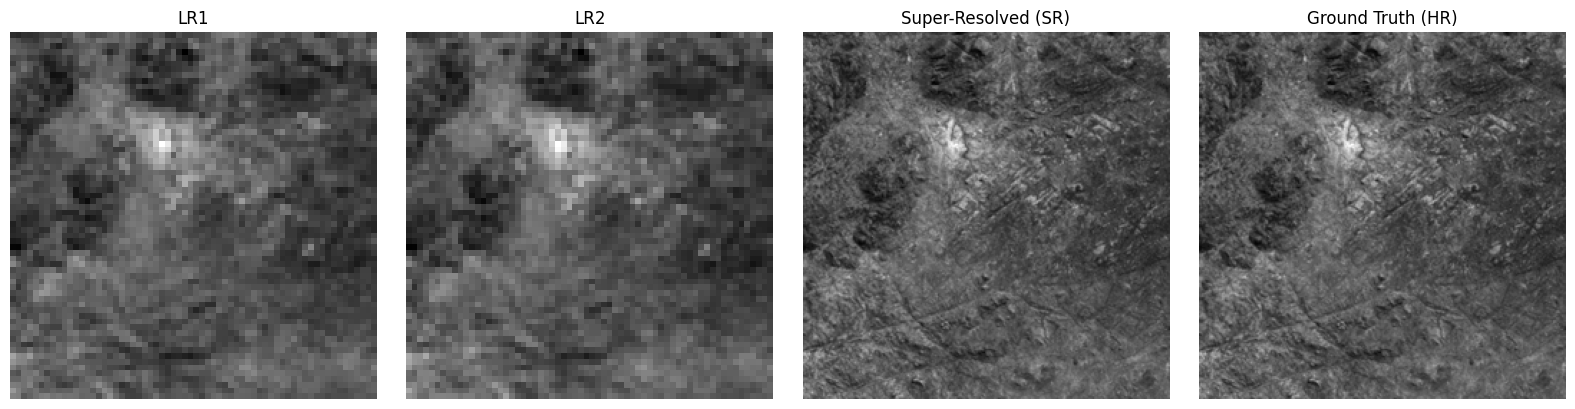

✅ Saved: Image_outputs/visuals/lr1_sample_5.png, Image_outputs/visuals/lr2_sample_5.png,Image_outputs/visuals/sr_sample_5.png, Image_outputs/visuals/hr_sample_5.png, 


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import os
import torch

# Ensure model is in evaluation mode
model.eval()

# Create output directory
os.makedirs("Image_outputs/visuals", exist_ok=True)

# Visualize first few test samples
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        lr1 = batch['lr1'].to(device)
        lr2 = batch['lr2'].to(device)
        hr  = batch['hr'].to(device)

        sr = model(lr1, lr2)

        # Remove batch dimension and move to CPU for visualization
        lr1_img = TF.to_pil_image(lr1[0].cpu())
        lr2_img = TF.to_pil_image(lr2[0].cpu())
        sr_img  = TF.to_pil_image(sr[0].cpu().clamp(0, 1))
        hr_img  = TF.to_pil_image(hr[0].cpu())

        # Plot all images side by side (with HR in SR's place)
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(lr1_img, cmap='gray')
        axes[0].set_title("LR1")
        axes[0].axis('off')

        axes[1].imshow(lr2_img, cmap='gray')
        axes[1].set_title("LR2")
        axes[1].axis('off')

        # 🔄 Display HR image & SR image
        axes[2].imshow(sr_img, cmap='gray')
        axes[2].set_title("Super-Resolved (SR)") 
        axes[2].axis('off')

        axes[3].imshow(hr_img, cmap='gray')
        axes[3].set_title("Ground Truth (HR)")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # Save images
        sr_filename = f"Image_outputs/visuals/sr_sample_{i}.png"
        hr_filename = f"Image_outputs/visuals/hr_sample_{i}.png"
        lr1_filename = f"Image_outputs/visuals/lr1_sample_{i}.png"
        lr2_filename = f"Image_outputs/visuals/lr2_sample_{i}.png"

        sr_img.save(sr_filename)
        hr_img.save(hr_filename)
        lr1_img.save(lr1_filename)
        lr2_img.save(lr2_filename)

        print(f"✅ Saved: {lr1_filename}, {lr2_filename},{sr_filename}, {hr_filename}, ")

        if i >= 5:
            break
